In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import Logit
import patsy

## Process the raw training data

In [2]:
with pd.HDFStore("out/Training_2002_2005.middle.h5") as store:
    print(store)
    df = store["middle_2nd_author"]

<class 'pandas.io.pytables.HDFStore'>
File path: out/Training_2002_2005.middle.h5
/middle_2nd_author            frame        (shape->[34032575,56])


In [3]:
df.head()

,source_id,source_year,source_j,source_n_mesh,source_n_mesh_ex,source_is_eng,source_country,source_is_journal,source_is_review,source_is_case_rep,...,eth1,eth2,pos,pos_nice,sink_last_ncites,sink_prev_ncites,auth_last_npapers,auth_prev_papers,jj_sim,is_self_cite
0,15543590,2005,J Med Virol,15,82,1,JAPAN,1,0,0,...,JAPANESE,UNKNOWN,2,2,5,97,2,1,18.0488,0
1,15543590,2005,J Med Virol,15,82,1,JAPAN,1,0,0,...,JAPANESE,UNKNOWN,2,2,3,42,2,1,0.0000,0
2,15543590,2005,J Med Virol,15,82,1,JAPAN,1,0,0,...,JAPANESE,UNKNOWN,2,2,5,77,2,1,0.0000,0
3,15543590,2005,J Med Virol,15,82,1,JAPAN,1,0,0,...,JAPANESE,UNKNOWN,2,2,8,198,2,1,19.3836,0
4,15543590,2005,J Med Virol,15,82,1,JAPAN,1,0,0,...,JAPANESE,UNKNOWN,2,2,8,17,2,1,0.0000,0


In [4]:
df.columns

Index([u'source_id', u'source_year', u'source_j', u'source_n_mesh',
       u'source_n_mesh_ex', u'source_is_eng', u'source_country',
       u'source_is_journal', u'source_is_review', u'source_is_case_rep',
       u'source_is_let_ed_com', u'source_T_novelty', u'source_V_novelty',
       u'source_PT_novelty', u'source_PV_novelty', u'source_ncites',
       u'source_n_authors', u'sink_id', u'sink_year', u'sink_j',
       u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng', u'sink_is_journal',
       u'sink_is_review', u'sink_is_case_rep', u'sink_is_let_ed_com',
       u'sink_T_novelty', u'sink_V_novelty', u'sink_PT_novelty',
       u'sink_PV_novelty', u'sink_n_authors', u'year_span', u'journal_same',
       u'mesh_sim', u'title_sim', u'lang_sim', u'affiliation_sim',
       u'pubtype_sim', u'cite_sim', u'author_sim', u'gender_sim', u'eth_sim',
       u'n_common_authors', u'auid', u'gender', u'eth1', u'eth2', u'pos',
       u'pos_nice', u'sink_last_ncites', u'sink_prev_ncites',
       u'auth_l

In [5]:
df["eth_weight"] = 0.5 # Partial weight to multi ethnicity
df.ix[df.eth2 == "UNKNOWN", "eth_weight"] = 1 # Full weight to single ethnicity

## Top 15 countries in PUBMED using MapAffil

```
SELECT mapaffil_author, COUNT(PMID) as C FROM Country GROUP BY mapaffil_author ORDER BY C DESC LIMIT 50;
```


```
USA	5630449
-	5381526
UK	1258220
JAPAN	1093784
GERMANY	943164
FRANCE	683470
ITALY	596575
CANADA	535345
CHINA	445054
AUSTRALIA	338799
SPAIN	332491
NETHERLANDS	315492
SWEDEN	277981
INDIA	255261
SWITZERLAND	206675
```

In [6]:
df.ix[df.source_country == "-", "source_country"] = "UNKNOWN" # Set - to unknown

In [7]:
TOP_15_COUNTRIES = ["USA", "UNKNOWN", "UK", "JAPAN", "GERMANY", "FRANCE", "ITALY",
                    "CANADA", "CHINA", "AUSTRALIA", "SPAIN", "NETHERLANDS",
                    "SWEDEN", "INDIA", "OTHER"]

In [8]:
df.source_country = df.source_country.astype("category", categories=TOP_15_COUNTRIES, ordered=False).fillna("OTHER")

In [9]:
df.source_country.cat.categories

Index([u'USA', u'UNKNOWN', u'UK', u'JAPAN', u'GERMANY', u'FRANCE', u'ITALY',
       u'CANADA', u'CHINA', u'AUSTRALIA', u'SPAIN', u'NETHERLANDS', u'SWEDEN',
       u'INDIA', u'OTHER'],
      dtype='object')

## Top ethnicities

Multiple ethnicities are given partial weight

Code
```
df_author = pd.read_csv("data/AuthorEthGender.txt", sep="\t")
df_author["eth_weight"] = df_author.Ethnea.str.split("-").apply(lambda x: 1. / len(x))
df_author[["eth1", "eth2"]] = df_author.Ethnea.str.split("-", expand=True)
t = pd.concat([df_author.groupby("eth1")["eth_weight"].sum(),
               df_author.groupby("eth2")["eth_weight"].sum()],
             axis=1).sum(axis=1)
t.sort_values(ascending=False)
```

```
ENGLISH       2782108.5
GERMAN         906626.0
HISPANIC       824886.5
CHINESE        733996.5
JAPANESE       729496.0
SLAV           600884.5
FRENCH         549123.5
ITALIAN        425322.0
INDIAN         312127.5
NORDIC         304026.0
ARAB           253439.5
DUTCH          213680.0
KOREAN         138553.5
ISRAELI        126600.5
TURKISH         84244.0
GREEK           74970.0
AFRICAN         68456.5
UNKNOWN         49239.0
HUNGARIAN       44897.0
THAI            32824.0
ROMANIAN        24788.0
BALTIC           8647.5
VIETNAMESE       5267.0
INDONESIAN       3043.5
CARIBBEAN        2002.5
TOOSHORT          626.0
MONGOLIAN         188.5
POLYNESIAN         85.0
ERROR              33.0
```

In [10]:
df.ix[df.eth1.isin(
        ["UNKNOWN", "TOOSHORT", "ERROR"]),
      "eth1"] = "UNKNOWN" # Set unknown ethnicities
df.ix[df.eth2.isin(
        ["UNKNOWN", "TOOSHORT", "ERROR"]),
      "eth2"] = "UNKNOWN" # Set unknown ethnicities

In [11]:
TOP_15_ETHNICITIES = ["ENGLISH", "GERMAN", "HISPANIC", "CHINESE",
                      "JAPANESE", "SLAV", "FRENCH", "ITALIAN", "INDIAN",
                      "NORDIC", "ARAB", "DUTCH", "KOREAN", "UNKNOWN", "OTHER"]

In [12]:
df.eth1 = df.eth1.astype("category", categories=TOP_15_ETHNICITIES, ordered=False).fillna("OTHER")
df.eth2 = df.eth2.astype("category", categories=TOP_15_ETHNICITIES, ordered=False).fillna("OTHER")

## Gender

In [13]:
GENDERS = ["-", "F", "M"]

In [14]:
df.gender = df.gender.astype("category", categories=GENDERS, ordered=False).fillna("-")

## Change dtype of comparisons to boolean
Make sure `is_self_cite` is not set to bool. Change its values in the resulting files as well.

In [15]:
df[[u'source_is_eng', u'source_is_journal', u'source_is_review',
    u'source_is_case_rep', u'source_is_let_ed_com',
    u'sink_is_eng', u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
    u'sink_is_let_ed_com', u'journal_same', u'affiliation_sim']] = df[[u'source_is_eng', u'source_is_journal', u'source_is_review',
    u'source_is_case_rep', u'source_is_let_ed_com',
    u'sink_is_eng', u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
    u'sink_is_let_ed_com', u'journal_same', u'affiliation_sim']].astype("bool")

In [16]:
df.dtypes

source_id                  int64
source_year                int64
source_j                  object
source_n_mesh              int64
source_n_mesh_ex           int64
source_is_eng               bool
source_country          category
source_is_journal           bool
source_is_review            bool
source_is_case_rep          bool
source_is_let_ed_com        bool
source_T_novelty         float64
source_V_novelty         float64
source_PT_novelty        float64
source_PV_novelty        float64
source_ncites              int64
source_n_authors           int64
sink_id                    int64
sink_year                  int64
sink_j                    object
sink_n_mesh                int64
sink_n_mesh_ex             int64
sink_is_eng                 bool
sink_is_journal             bool
sink_is_review              bool
sink_is_case_rep            bool
sink_is_let_ed_com          bool
sink_T_novelty           float64
sink_V_novelty           float64
sink_PT_novelty          float64
sink_PV_no

## Store model data

In [17]:
df = df.drop(["source_j", "sink_j", "auid"], axis=1)
df.shape

(34032575, 54)

In [18]:
with pd.HDFStore('out/ModelData.20171219.h5') as cstore:
    cstore.append(
        'middle_2nd_author',
        df,
        format='table',
        data_columns=['source_country','gender', 'eth1', 'eth2'])

## Load data from HDF5

In [19]:
with pd.HDFStore('out/ModelData.20171219.h5') as cstore:
    df = cstore['middle_2nd_author']

## Model data generation

In [20]:
import model_functions as mf

MF reloaded 1


In [21]:
GENDERS = ["-", "F", "M"]
TOP_15_ETHNICITIES = ["ENGLISH", "GERMAN", "HISPANIC", "CHINESE",
                      "JAPANESE", "SLAV", "FRENCH", "ITALIAN", "INDIAN",
                      "NORDIC", "ARAB", "DUTCH", "KOREAN", "UNKNOWN", "OTHER"]
TOP_15_COUNTRIES = ["USA", "UNKNOWN", "UK", "JAPAN", "GERMANY", "FRANCE", "ITALY",
                    "CANADA", "CHINA", "AUSTRALIA", "SPAIN", "NETHERLANDS",
                    "SWEDEN", "INDIA", "OTHER"]

sns.set_context("poster")
sns.set_style("ticks")

In [22]:
def logit(p):
    return np.log(p/(1-p))


def get_empirical_logit(df, X_col, y_col, conditioning_var="Gender",
    bins=None, testing=False):
    if testing:
        # If testing the just print X and y columns
        print X_col, y_col
        return conditioning_var, ({"llf": 0.1}, "TEMP SUMMARY")
    ## Not testing. Fit the models and return the measures
    print X_col, conditioning_var, y_col
    t = df.pivot_table(index=pd.cut(df[X_col], bins=bins),
      columns=conditioning_var, values=y_col,
      aggfunc=[np.mean, len])
    t = t.set_index(bins[1:])
    return t


auth_prev_papers
auth_prev_papers gender is_self_cite
sink_prev_ncites
sink_prev_ncites gender is_self_cite
source_n_mesh_ex
source_n_mesh_ex gender is_self_cite
sink_n_mesh_ex
sink_n_mesh_ex gender is_self_cite
jj_sim
jj_sim gender is_self_cite
year_span
year_span gender is_self_cite
source_ncites
source_ncites gender is_self_cite
source_n_authors
source_n_authors gender is_self_cite


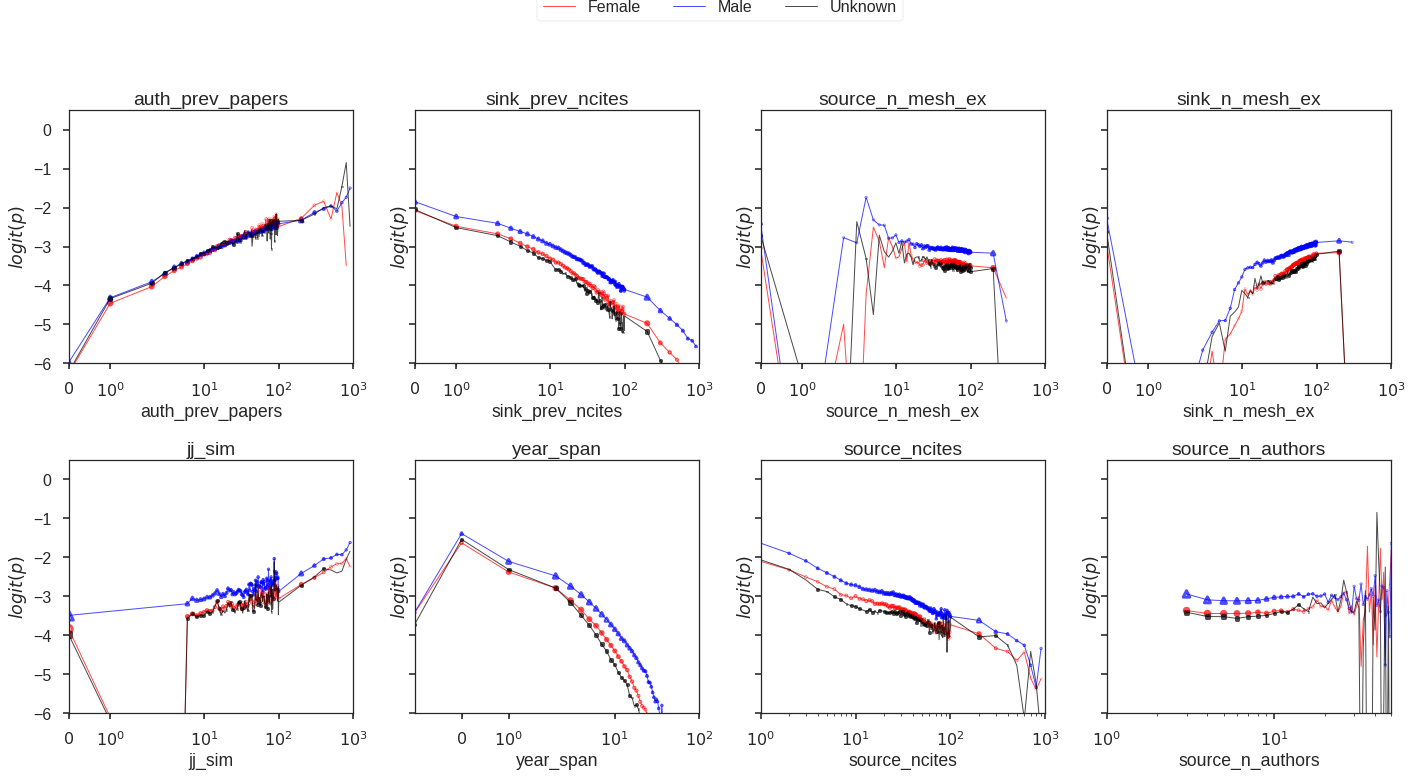

In [23]:
colors = ["r", "b", "k"]
markers = ["o", "^", "s"]
conditioning_names = ["F", "M", "-"]
cm = plt.cm.get_cmap('Greys')
plt.clf()
plt.close("all")
fig, ax = plt.subplots(2,4, sharey=True, figsize=(20,10))
ax = ax.flatten()
plot_id = 0
y_feature_col = "is_self_cite"
xcols = ["auth_prev_papers", "sink_prev_ncites", 
         "source_n_mesh_ex", "sink_n_mesh_ex", "jj_sim",
         "year_span", "source_ncites", "source_n_authors"]
for k in xcols:
    if k in ["auth_prev_papers", "sink_prev_ncites", "source_n_mesh_ex", "sink_n_mesh_ex", "jj_sim"]:
        bins = np.array([-0.1] + range(100) + range(100,1000,100))
        xscale = "symlog"
        xlims = [0, 1000]
    if k in ["source_ncites"]:
        bins = np.array(range(-1,100) + range(100,1000,100))
        xscale = "log"
        xlims = [1, 1000]
    if k in ["source_n_authors"]:
        bins = np.array(range(-1,100) + range(100,1000,100))
        xscale = "log"
        xlims = [1, 50]
    if k in ["year_span"]:
        bins = np.array([-10, -1] + range(100))
        xscale = "symlog"
        xlims = [-1, 100]
    print k
    t = get_empirical_logit(df, k, y_feature_col,
    conditioning_var="gender",
    bins=bins,
    testing=False)
    t_logit = logit(t["mean"]).clip(-10,10)
    lgd_items = []
    for j,c in enumerate(conditioning_names):
        scp = ax[plot_id].scatter(t_logit.index, t_logit[c], edgecolor=colors[j], s=t["len"][c] / 1e5, 
                                  facecolor='none', alpha=0.7, linewidth=3, marker=markers[j])
        line, = ax[plot_id].plot(t_logit[t_logit[c].notnull()].index, t_logit[t_logit[c].notnull()][c],
                                 marker="None", linestyle="-", color=colors[j], label=c, lw=1, alpha=0.7)
        lgd_items.append(line)
    ax[plot_id].set_xlabel(k)
    ax[plot_id].set_ylabel("$logit(p)$")
    ax[plot_id].set_title(k)
    ax[plot_id].set_xscale(xscale)
    ax[plot_id].set_xlim(xlims)
    ax[plot_id].set_ylim((-6,0.5))
    plot_id += 1
plt.margins(0.1)
#ax.legend(handles=lgd_items, loc="upper center", ncol=3)
lgd = fig.legend(lgd_items, ["Female", "Male", "Unknown"],
                 loc = 'upper center',
                 bbox_to_anchor=(0.5,1.1), ncol=3,
                 frameon=True, fancybox=True, prop={"size": 16})
fig.tight_layout()
plt.savefig("Review_2_Figures/Empirical_1.middle_2nd_author.pdf")

source_T_novelty
source_T_novelty gender is_self_cite
source_V_novelty
source_V_novelty gender is_self_cite
source_PT_novelty
source_PT_novelty gender is_self_cite
source_PV_novelty
source_PV_novelty gender is_self_cite
sink_T_novelty
sink_T_novelty gender is_self_cite
sink_V_novelty
sink_V_novelty gender is_self_cite
sink_PT_novelty
sink_PT_novelty gender is_self_cite
sink_PV_novelty
sink_PV_novelty gender is_self_cite


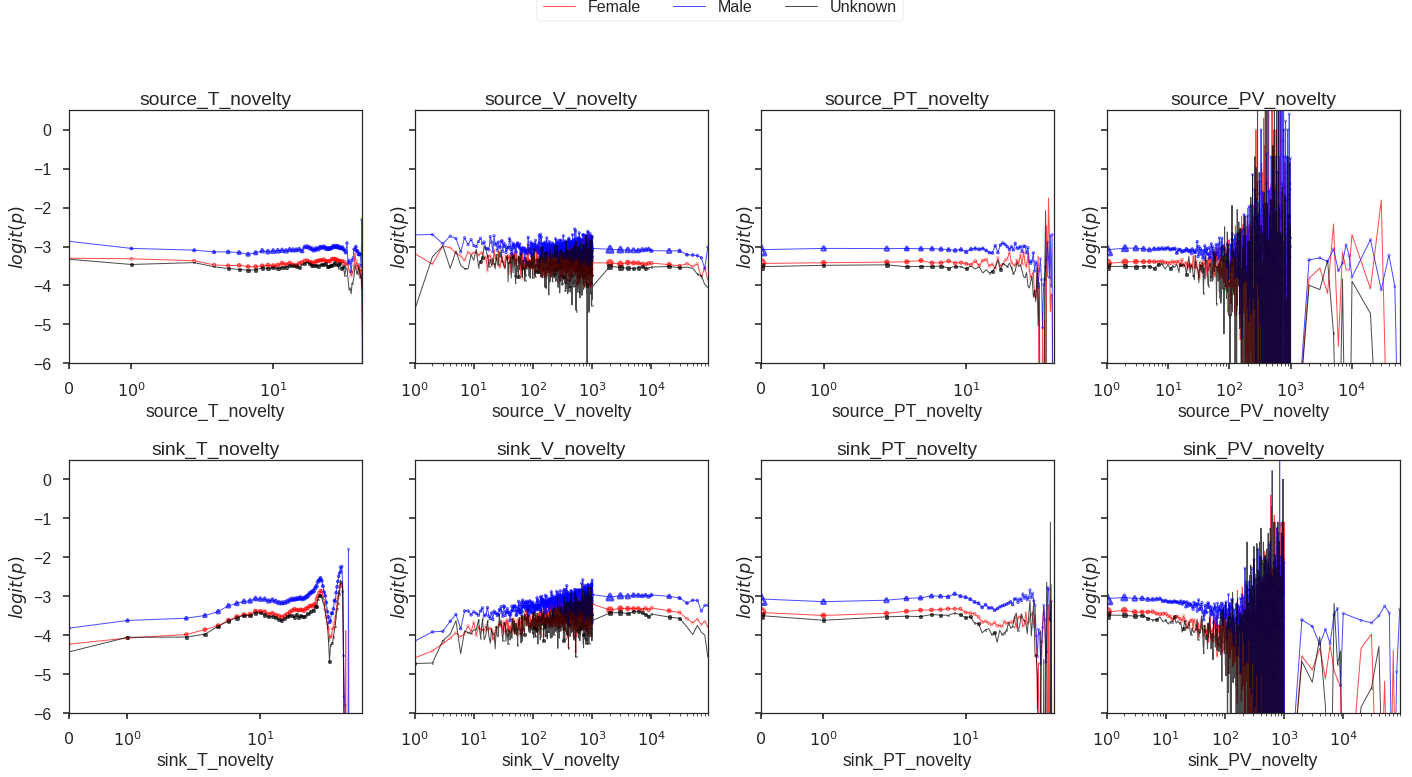

In [24]:
colors = ["r", "b", "k"]
markers = ["o", "^", "s"]
conditioning_names = ["F", "M", "-"]
cm = plt.cm.get_cmap('Greys')
plt.clf()
plt.close("all")
fig, ax = plt.subplots(2,4, sharey=True, figsize=(20,10))
ax = ax.flatten()
plot_id = 0
y_feature_col = "is_self_cite"
xcols = ["source_T_novelty", "source_V_novelty", 
         "source_PT_novelty", "source_PV_novelty",
         "sink_T_novelty", "sink_V_novelty", 
         "sink_PT_novelty", "sink_PV_novelty",]
for k in xcols:
    if k in ["source_T_novelty", "source_PT_novelty", "sink_T_novelty", "sink_PT_novelty"]:
        bins = np.array([-1] + range(0,100) + range(100,1000,100))
        xscale = "symlog"
        #xlims = [0, 1000]
    if k in ["source_V_novelty", "source_PV_novelty", "sink_V_novelty", "sink_PV_novelty"]:
        bins = np.array(range(0,1000) + range(1000,10000,1000) + range(10000,100000, 10000))
        xscale = "log"
        #xlims = [1, 1000]
    print k
    t = get_empirical_logit(df, k, y_feature_col,
    conditioning_var="gender",
    bins=bins,
    testing=False)
    t_logit = logit(t["mean"]).clip(-10,10)
    lgd_items = []
    for j,c in enumerate(conditioning_names):
        scp = ax[plot_id].scatter(t_logit.index, t_logit[c], edgecolor=colors[j], s=t["len"][c] / 1e5, 
                                  facecolor='none', alpha=0.7, linewidth=3, marker=markers[j])
        line, = ax[plot_id].plot(t_logit[t_logit[c].notnull()].index, t_logit[t_logit[c].notnull()][c],
                                 marker="None", linestyle="-", color=colors[j], label=c, lw=1, alpha=0.7)
        lgd_items.append(line)
    xlims = [t_logit[t_logit[c].notnull()].index.min(),
             t_logit[t_logit[c].notnull()].index.max()]
    ax[plot_id].set_xlabel(k)
    ax[plot_id].set_ylabel("$logit(p)$")
    ax[plot_id].set_title(k)
    ax[plot_id].set_xscale(xscale)
    ax[plot_id].set_xlim(xlims)
    ax[plot_id].set_ylim((-6,0.5))
    plot_id += 1

#ax.legend(handles=lgd_items, loc="upper center", ncol=3)
lgd = fig.legend(lgd_items, ["Female", "Male", "Unknown"],
                 loc = 'upper center',
                 bbox_to_anchor=(0.5,1.1), ncol=3,
                 frameon=True, fancybox=True, prop={"size": 16})
fig.tight_layout()
plt.savefig("Review_2_Figures/Empirical_2.middle_2nd_author.pdf")

## Model specificantions

**V3** - Doesn't have `+ I(auth_prev_papers == 1)`

**V4** - Does have `+ I(auth_prev_papers == 1) + I(np.log10(source_ncites)**3)`

In [26]:
formula = ("is_self_cite ~ I(auth_prev_papers == 0) + I(auth_prev_papers == 1) + np.log10(auth_prev_papers + 1)"
           "+ C(gender, levels=GENDERS) + C(source_country, levels=TOP_15_COUNTRIES)"
           "+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           "+ I(source_ncites == 1) + np.log10(source_ncites)"
           "+ I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)"
           "+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))"
           "+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)"
           "+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)" 
           "+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same"
           "+ source_is_eng + source_is_journal + source_is_review + source_is_case_rep + source_is_let_ed_com"
           "+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
           "+ np.log10(np.nan_to_num(source_V_novelty) + 1)"
           "+ np.log10(np.nan_to_num(sink_V_novelty) + 1) + I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"
          )
y,X = patsy.dmatrices(formula, data=df, return_type="dataframe")
print X.shape, y.shape

Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
(34032575, 69) (34032575, 1)


In [27]:
X.columns

Index([u'Intercept', u'I(auth_prev_papers == 0)[T.True]',
       u'I(auth_prev_papers == 1)[T.True]', u'C(gender, levels=GENDERS)[T.F]',
       u'C(gender, levels=GENDERS)[T.M]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.UK]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]',
       u'C(source_country, levels=TOP_15_COUNTRIES)

In [28]:
y.columns

Index([u'is_self_cite'], dtype='object')

In [29]:
model = Logit(y,X)
res = model.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.131096
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                    Results: Logit
======================================================================================================================
Model:                               Logit                             Pseudo R-squared:                  0.199       
Dependent Variable:                  is_self_cite                      AIC:                               8923185.3016
Date:                                2017-12-19 15:16                  BIC:                               8924243.9568
No. Observations:                    34032575                          Log-Likelihood:                    -4.4615e+06 
Df Model:                            68                                LL-Null:                           -5.5671e+06 
Df Residuals:                        34032506                          LLR p-value:                       0.0000      
Converged:                           1.0000                            Scale:                             1.0000      
No. Iterations:                      10.0000                                                                          
----------------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                                            -1.7404   0.0425  -40.9977 0.0000 -1.8237 -1.6572
I(auth_prev_papers == 0)[T.True]                                     -1.9878   0.0099 -200.1104 0.0000 -2.0073 -1.9683
I(auth_prev_papers == 1)[T.True]                                     -0.4948   0.0059  -83.5471 0.0000 -0.5064 -0.4832
C(gender, levels=GENDERS)[T.F]                                        0.0325   0.0040    8.0962 0.0000  0.0246  0.0403
C(gender, levels=GENDERS)[T.M]                                       -0.0401   0.0037  -10.7513 0.0000 -0.0474 -0.0328
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                -0.0308   0.0082   -3.7546 0.0002 -0.0469 -0.0147
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                     -0.0079   0.0040   -1.9696 0.0489 -0.0157 -0.0000
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                   0.2013   0.0070   28.6787 0.0000  0.1876  0.2151
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                -0.0399   0.0050   -7.9884 0.0000 -0.0497 -0.0301
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                 -0.0510   0.0060   -8.5239 0.0000 -0.0627 -0.0392
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                  -0.0172   0.0071   -2.4023 0.0163 -0.0312 -0.0032
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                 -0.0405   0.0052   -7.7413 0.0000 -0.0508 -0.0303
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                  -0.4854   0.0106  -45.6266 0.0000 -0.5062 -0.4645
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]               0.0557   0.0063    8.8092 0.0000  0.0433  0.0681
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]                   0.0261   0.0071    3.7027 0.0002  0.0123  0.0400
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]            -0.0379   0.0077   -4.9488 0.0000 -0.0529 -0.0229
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]                  0.0319   0.0076    4.2231 0.0000  0.0171  0.0467
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]                  -0.0312   0.0132   -2.3574 0.0184 -0.0572 -0.0053
C(source_country, levels=TOP_15_COUNTRIES)[T.OTHER]                  -0.0785   0.0032  -24.5470 0.0000 -0.0848 -0.0723
I(source_ncites == 1)[T.True]                                        -0.1796   0.0285   -6.3111 0.0000 -0.2353 -0.1238
I(source_n_authors > 20)[T.True]                                     -0.0910

In [30]:
# Bumped version number to v4
with pd.HDFStore("out/Model.v4.middle_2nd_author.h5", mode="w",) as store:
    store.put("X", X, format="table")
    print "Finished X"
    store.put("y", y, format="table")
    print "Finished y"

Finished X
Finished y


In [31]:
X.shape

(34032575, 69)

In [32]:
df.shape

(34032575, 54)